In this code we simulate NV diamond's ODMR spectra. Our goal is to simulate the resonance frequencies and lineshape using the time depedent solver.

Linewidth is determined by T1 and T2 times

Resonance frequencies are determined by static Hamiltonian with D-field and Zeeman splitting terms (for Mag field and strain field)

@zahmed

In [1]:
pip install qutip

In [2]:
#import modules

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [3]:
#### Define constant parameters
D = 2 * np.pi * 2.87e9  # D-field rad/s
gamma_nv = 2 * np.pi * 2.8e6  # Gyromagnetic ratio of NV (rad/s/G)
B = 0  # incident magnetic field (Gauss)

### Strain parameters
# Transverse strain splitting (rad/s), suggested values: 0-50 MHz
E = 2 * np.pi * 2.5e6  *2
# Angle of strain axis in xy plane (radians)
strain_angle = np.pi / 4

## Decay rates
gamma1 = 2 * np.pi * 2e6
gamma2 = 2 * np.pi * 1e6

# Rabi frequency (rad/s)
omega_rabi = 2 * np.pi * 0.01e6

### Define spin operators
sz = Qobj([[1, 0, 0], [0, 0, 0], [0, 0, -1]])  # spin z
sx = Qobj([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)  # Spin x
sy = Qobj([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]]) / np.sqrt(2)  # Spin y

# Identity operator
I = qeye(3)

In [4]:
# ============================================================================
# Calculate center frequency using diagonalization
# ============================================================================


# Build static Hamiltonian (w/o MW drive), diagonalize the static Hamiltonian
H_static = D * sz * sz + gamma_nv * B * sz
sx2 = sx * sx
sy2 = sy * sy
sxsy = sx * sy + sy * sx
H_strain_static = E * (np.cos(2 * strain_angle) * (sx2 - sy2) +
                        np.sin(2 * strain_angle) * sxsy)
H_static_full = H_static + H_strain_static

# Diagonalize to get energy eigenvalues
eigenvals, eigenvecs = H_static_full.eigenstates()
eigenvals_sorted = np.sort(eigenvals.real)

# Energy levels: E0 (|0⟩), E+1 (|+1⟩), E-1 (|-1⟩)
E0 = eigenvals_sorted[0]  # |0⟩
E_plus1 = eigenvals_sorted[1]  # |+1⟩
E_minus1 = eigenvals_sorted[2]  # |-1⟩

# Transition frequencies (convert from rad/s to Hz)
freq_trans_plus = abs(E_plus1 - E0) / (2 * np.pi)  # |0⟩ ↔ |+1⟩
freq_trans_minus = abs(E_minus1 - E0) / (2 * np.pi)  # |0⟩ ↔ |-1⟩

# Center frequency as average of the two transitions (includes strain effect)
freq_center = (freq_trans_plus + freq_trans_minus) / 2


In [5]:
# Time-dependent Hamiltonian
def H_time_dependent(t, args):
    """
    Time-dependent Hamiltonian in lab frame.
    args: {'mw_freq': frequency in Hz}
    """
    omega_mw = 2 * np.pi * args['mw_freq']

    # Static part (ZFS + Zeeman + Strain)
    H_static = H_static_full

    # Time-dependent MW drive: omega_rabi * cos(omega_mw * t) * sx
    H_mw_t = omega_rabi * np.cos(omega_mw * t) * sx

    return H_static + H_mw_t

# Collapse operators for dissipation
c_ops = [
    np.sqrt(gamma1) * (basis(3, 0) * basis(3, 1).dag()),  # |+1⟩ → |0⟩
    np.sqrt(gamma1) * (basis(3, 0) * basis(3, 2).dag()),  # |-1⟩ → |0⟩
    np.sqrt(gamma2) * sz,  # Pure dephasing
]

## Frequency sweep for ODMR
# Increase resolution to better resolve the peaks
freq_range = np.linspace(freq_center - 15e6, freq_center + 15e6, 100)  # higher the rez, longer the sim time
fluorescence = []

# Calculate frequency resolution [added for diagnostic purposes]
freq_resolution = (freq_range[-1] - freq_range[0]) / (len(freq_range) - 1) / 1e6  # MHz per point
print(f"Frequency resolution: {freq_resolution:.3f} MHz per point")
print(f"Linewidth (~0.11 MHz) should be resolved with this resolution\n")

print("Simulating ODMR spectrum...")
print(f"Zero-field splitting: {D/(2*np.pi*1e9):.2f} GHz")
print(f"Magnetic field: {B} G")
print(f"Strain field: {E/(2*np.pi*1e6):.2f} MHz")
print(f"Strain angle: {strain_angle*180/np.pi:.1f} degrees")
print(f"\nCenter frequency (with strain): {freq_center/1e9:.6f} GHz")
print(f"Transition frequencies:")
print(f"  |0⟩ ↔ |+1⟩: {freq_trans_plus/1e9:.6f} GHz")
print(f"  |0⟩ ↔ |-1⟩: {freq_trans_minus/1e9:.6f} GHz")
print(f"Expected resonances: {freq_trans_plus/1e9:.6f} GHz and {freq_trans_minus/1e9:.6f} GHz\n")



Frequency resolution: 0.303 MHz per point
Linewidth (~0.11 MHz) should be resolved with this resolution

Simulating ODMR spectrum...
Zero-field splitting: 2.87 GHz
Magnetic field: 0 G
Strain field: 5.00 MHz
Strain angle: 45.0 degrees

Center frequency (with strain): 2.870000 GHz
Transition frequencies:
  |0⟩ ↔ |+1⟩: 2.865000 GHz
  |0⟩ ↔ |-1⟩: 2.875000 GHz
Expected resonances: 2.865000 GHz and 2.875000 GHz



In [6]:
# ============================================================================
# ODMR Simulation with Time-Dependent Hamiltonian
# ============================================================================


# Initial state (thermal equilibrium, mostly in |0⟩)
psi0 = basis(3, 0)

# Time evolution parameters
gamma1_hz = gamma1 / (2 * np.pi)  # Convert to Hz
T1_estimate = 1 / gamma1_hz  # seconds
t_max = 5 * T1_estimate  # Use 5× T1 to ensure steady state
n_points = 100
times = np.linspace(0, t_max, n_points)
print(f"Simulation time: {t_max*1e6:.2f} μs (T1 ≈ {T1_estimate*1e6:.2f} μs)")
print(f"Ensuring steady state is reached...\n")

# Prepare time-dependent Hamiltonian format for mesolve
# H0 is static, H1 is time-dependent with function func1(t, args)

fluorescence = []

# Simulate for each frequency
for i, freq in enumerate(freq_range):
    if i % 10 == 0 or i == len(freq_range) - 1:
        print(f"Progress: {i+1}/{len(freq_range)}")

    H_td = [H_static_full,
            [omega_rabi * sx, lambda t, args: np.cos(2 * np.pi * args['mw_freq'] * t)]]
    H_args = {'mw_freq': freq}
    result = mesolve(H_td, psi0, times, c_ops, [basis(3, 0) * basis(3, 0).dag()],
                     args=H_args, options={'nsteps': 100000, 'max_step': 1e-9})
    fluor = result.expect[0][-1]  # Final population in |0⟩
    fluorescence.append(fluor)

print('converting list to numpy array')
fluorescence = np.array(fluorescence)


Simulation time: 2.50 μs (T1 ≈ 0.50 μs)
Ensuring steady state is reached...

Progress: 1/100


/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Progress: 11/100
Progress: 21/100
Progress: 31/100
Progress: 41/100
Progress: 51/100
Progress: 61/100
Progress: 71/100
Progress: 81/100
Progress: 91/100
Progress: 100/100
converting list to numpy array


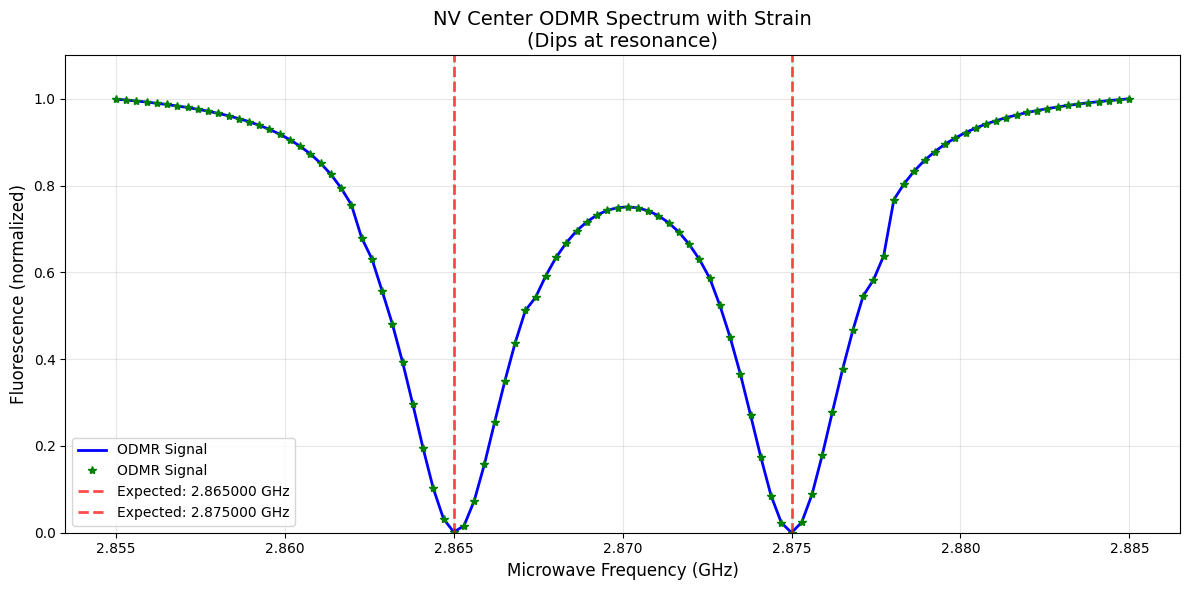

In [7]:
# ============================================================================
# Plot ODMR Spectrum
# ============================================================================

# Normalize and show dips directly
fluorescence_normalized = (fluorescence - fluorescence.min()) / (fluorescence.max() - fluorescence.min())
fluorescence_plot = fluorescence_normalized

# Plot ODMR spectrum
plt.figure(figsize=(12, 6))
plt.plot(freq_range / 1e9, fluorescence_plot, 'b-', linewidth=2, label='ODMR spectra')
plt.plot(freq_range / 1e9, fluorescence_plot, 'g*', linewidth=2, label='ODMR spectra')
plt.xlabel('MW Freq (GHz)', fontsize=12)
plt.ylabel('Fluorescence (AU)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.1])

# Mark expected resonances w/ red lines
resonance1 = freq_trans_plus / 1e9
resonance2 = freq_trans_minus / 1e9
plt.axvline(resonance1, color='r', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Expected: {resonance1:.6f} GHz')
plt.axvline(resonance2, color='r', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Expected: {resonance2:.6f} GHz')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()